# <a id='the_top'>Random max-cut using <a href='https://en.wikipedia.org/wiki/Simulated_annealing'>simulated annealing</a></a>

Here we solve the problem of random maxcut defined in a <a href='https://github.com/animeshnanda1/Random_maxcut/blob/main/random_maxcut_qaoa_ed.ipynb'>this notebook</a>. 

The strategy is very similar to <a href='https://github.com/animeshnanda1/Random_maxcut/blob/main/random_maxcut_monte_carlo.ipynb'>MCMC notebook</a>, where we used a monte carlo simulation to find out the most vistited state (presumably the ground state) at a constant temperature. The only difference is, in this case we reduce the temperature during the monte carlo move, and the hope is at a very low temperature the system will <a href='https://en.wikipedia.org/wiki/Annealing_(metallurgy)'>'cool down'</a> to its GS.

For better understanding of the notion of temperature, see <a href='https://github.com/animeshnanda1/Random_maxcut/blob/main/random_maxcut_monte_carlo.ipynb'>MCMC notebook</a>.

Table of content:

* <a href='#the_problem'>The problem.</a>
* <a href='#set_up'>Setting up the sollution</a>
* <a href='#simulation'>Simulating the problem</a>
* <a href='#visual'>Visualizing the results</a>

In [1]:
# general packages
import numpy as np
import math
import networkx as nx

# for scintific computing
import scipy.sparse as sps
from functools import reduce
from collections import Counter

# visualization
import matplotlib.pyplot as plt

# <a id='the_problem'>Defining the problem</a>

In [2]:
L=7

# total number of bond 
N_all_possible=math.factorial(L)/(math.factorial(2)*(math.factorial(L-2)))
N_bond = int(N_all_possible//2)

s=list(range(L))
np.random.seed(391)

# there are L choose 2 (=66) possible random interactions, among them we are choosing 20. Furthermore
# the interactions are being chosen from a uniform distribution b/w [-1,1)

interactions=list(nx.generators.random_graphs.dense_gnm_random_graph(L,N_bond,seed=23).edges())
strength=np.random.choice([1,-1],size=N_bond,p=[.5,.5])
# strength=np.array([-1.]*N_bond)

J_nn=[[strength[i],interactions[i][0],interactions[i][1]] for i in range(N_bond)]
static=[["zz",J_nn]]

interactions;
static

[['zz',
  [[1, 0, 1],
   [1, 0, 2],
   [1, 0, 3],
   [-1, 1, 3],
   [1, 1, 4],
   [1, 1, 6],
   [1, 2, 5],
   [1, 2, 6],
   [-1, 3, 6],
   [-1, 4, 5]]]]

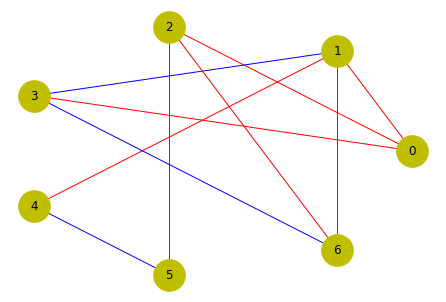

In [3]:
G = nx.Graph()
G.add_nodes_from(s)
for item in J_nn:
    G.add_edge(item[1],item[2],color='r' if (item[0]>0) else 'b',weight=item[0])

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
    
options = {
    'node_color': 'y',
    'node_size': 1000,
}
    
nx.draw(G,with_labels=True,pos=nx.circular_layout(G),edges=edges,edge_color=colors,width=weights,**options)

The problem is to find out a order in the nodes as `0` and `1`, such that all the bonds are 'happy'. Here the meaning of the 'happy' means the nodes are aligned (anti-aligned) for a blue (red) bond.

Furhter more using the $Z_2$ symmetry of the problem we will reduce the dimention of the problem to the 6 bit, i.e. the dimention is: $2^6=64$. (see <a href='https://github.com/animeshnanda1/Random_maxcut/blob/main/random_maxcut_monte_carlo.ipynb'>this notebook</a> for more details)

# <a id='set_up'>Setting up the sollution</a>

In [4]:
def calcEnergy(static,array):
    if len(array)==L-1:
        new_array=np.ndarray(shape=(L,))
        new_array[1:L]=array
        new_array[0]=0
        energy=0
        for item in static[0][1]:
            energy=energy+item[0]*(1-2*new_array[item[1]])*(1-2*new_array[item[2]])
    else:
        new_array=np.ndarray(shape=(L,))
        new_array[0:L]=array
        energy=0
        for item in static[0][1]:
            energy=energy+item[0]*(1-2*new_array[item[1]])*(1-2*new_array[item[2]])
    return energy

rL=L-1

def mcMove(state,T):
    new_state=np.random.randint(2**rL)
    e0=calcEnergy(state)
    e1=calcEnergy(new_state)
    eDel=e1-e0
    if eDel<0:
        return new_state
    elif np.random.rand() < np.exp(-eDel*(1./T)):
        return new_state
    else:
        return state

In [5]:
def int_to_binary_arr(x,rL):
    assert(x<=2**rL)
    local_array=np.zeros(shape=(rL,),dtype=np.int)
    index=0
    while x>0:
        local_array[index]=(int(x%2))
        x=x//2
        index=index+1
    return local_array[::-1]

def binary_arr_to_int(array,rL):
    summ=0
    for i,item in enumerate(array):
        summ += (2**(rL-1-i))*(item)
    assert(summ<2**rL)
    return summ

for j in range(2**7):
    assert(binary_arr_to_int(int_to_binary_arr(j,7),7)==j)

In [6]:
def mcMove(static,state_no,T):
        old_arr=int_to_binary_arr(state_no,rL)
        index=np.random.randint(rL)
        new_arr=np.array(old_arr)
        new_arr[index]=1-new_arr[index]
        e0=calcEnergy(static,old_arr)
        e1=calcEnergy(static,new_arr)
        eDel=e1-e0
        new_state=binary_arr_to_int(new_arr,rL)
        #print('state_no=%d, new_state=%d, eDel=%.2f'%(state_no,new_state,eDel))
        if eDel<0:
            #print('flip')
            return new_state
        elif np.random.rand() < np.exp(-eDel*(1./T)):
            #print('flip')
            return new_state
        else:
            #print('no flip')
            return state_no

# <a id='simulation'>Simulating the problem</a>

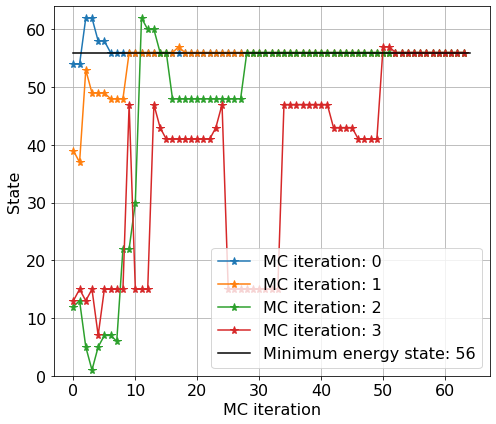


The maximum (minimum) temperature is 16.00 (0.25).




In [7]:
mcSweep=4
mcSteps=32*2
list_config=[]

np.random.seed(13368734)      # 4428799, 1162656, 13368734
speed=1

for k in range(mcSweep):
    init_config=np.random.randint(2**rL)
    for i in range(mcSteps):
        init_temp=16.
        temp=init_temp/(i+speed)
        new_config=mcMove(static,init_config,temp)
        init_config=new_config
        list_config.append(init_config)

new_list=np.array(list_config).reshape(mcSweep,mcSteps)

plt.figure(figsize=(7,6))
plt.ylim(0,64)
for k in range(mcSweep):
    plt.plot(np.arange(mcSteps),new_list[k,:],'*-',markersize=8,label='MC iteration: %d'%(k))
plt.plot([0,mcSteps],[56,56],'k-',label='Minimum energy state: 56')
plt.xlabel('MC iteration',fontsize=16)
plt.ylabel('State',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16,loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

print()
print('The maximum (minimum) temperature is %.2f (%.2f).'%(init_temp,init_temp/(mcSteps*speed)))
print()
print()

Clearly for different starting points, every simulation leads the state: 56, which is the best candidate state for the GS.

In the above code shell, the parameter 'speed' is interesting. We can reduce the temperature of the simulation with varying speed. Sometimes if the too fast, in the simulation we can get stuck in some local minima, whcih is unwanted. So sometimes it is usefull to do a simulation with varying speed to understand the configuration better.

# <a id='visual'>Visualizing the result</a>

In [8]:
short_string=int_to_binary_arr(56,rL)
new_string=np.ndarray(shape=(L,))

new_string[1:L]=short_string
new_string[0]=0

new_string

array([0., 1., 1., 1., 0., 0., 0.])

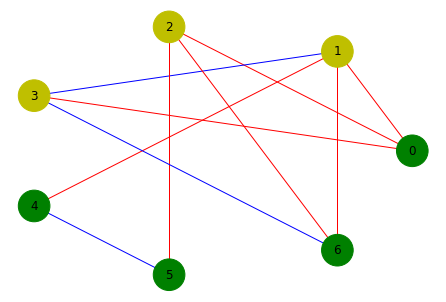

In [9]:
G = nx.Graph()
G.add_nodes_from(s)
for item in J_nn:
    G.add_edge(item[1],item[2],color='r' if (item[0]>0) else 'b',weight=item[0])

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
    
options = {'node_size': 1000,}

n_color=['g' if (node == 0) else 'y' for node in new_string]

nx.draw(G,node_color=n_color,with_labels=True,pos=nx.circular_layout(G),edges=edges,edge_color=colors,width=weights,**options)

<a href='#the_top'>Go to the top</a>